In [25]:
import numpy as np
# import seaborn as sns
import pandas as pd
import os.path

import matplotlib.pyplot as plt
import matplotlib as mpl

import tifffile 
# import czifile

from skimage import transform
from scipy import ndimage

import random 
import math

from skimage.registration import optical_flow_tvl1

In [26]:
####################
movie_dir =  '/mnt/d/lding/actomyosin/data/data_Wenhong'

filenames = [x for x in os.listdir(movie_dir) if os.path.isfile(os.path.join(movie_dir, x)) and ('.tif' in x)]

for filenameID in range(0,len(filenames)):
    print(filenames[filenameID])


processed_data_dir = '/mnt/d/lding/actomyosin/data/processed_data'
partitioned_data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data'
plot_dir = '/mnt/d/lding/actomyosin/data/prepareing_plots'

if not os.path.isdir(processed_data_dir):
    os.makedirs(processed_data_dir)
if not os.path.isdir(partitioned_data_dir):
    os.makedirs(partitioned_data_dir)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)



media-2-2.tif
VidS1.tif
VidS4_BlebbistatinWashout.tif
VidS4_BlebWO_stabilized.tif
VidS4_BlebWO_stabilized_not17.tif


In [27]:
def rotate_coor(x_i,y_i,x_c,y_c,rotate_angle):
 
    rotate_angle = rotate_angle*np.pi/180
 
    x_o = (x_i-x_c)*math.cos(rotate_angle) - (2*y_c-y_i-y_c)*math.sin(rotate_angle) +x_c
    y_o = -(x_i-x_c)*math.sin(rotate_angle) - (2*y_c-y_i-y_c)*math.cos(rotate_angle) +(2*y_c-y_c)

    return([x_o,y_o])

In [54]:
int_thresh = 0.1
patch_size = 48

plot_flag = 1
savetiff_flag = 1

filenames = [x for x in os.listdir(movie_dir) if os.path.isfile(os.path.join(movie_dir, x)) and ('.tif' in x)]

for filenameID in [0]:
# for filenameID in range(0,len(filenames)):

    filename = filenames[filenameID]

    # movie_processed_data_dir =  os.path.join(processed_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense')
    # movie_partitioned_data_dir =  os.path.join(partitioned_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense')
    # movie_plot_dir =  os.path.join(plot_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense')

    movie_processed_data_dir =  os.path.join(processed_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')
    movie_partitioned_data_dir =  os.path.join(partitioned_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')
    movie_plot_dir =  os.path.join(plot_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')


    if not os.path.isdir(movie_processed_data_dir):
        os.makedirs(movie_processed_data_dir)
    if not os.path.isdir(movie_partitioned_data_dir):
        os.makedirs(movie_partitioned_data_dir)
    if not os.path.isdir(movie_plot_dir):
        os.makedirs(movie_plot_dir)


    img = tifffile.imread(os.path.join(movie_dir,filename))
    img = img.astype(float)
    # img = img/(img.max())
    smooth_img = ndimage.gaussian_filter(img,sigma=1,mode='nearest',truncate=3)        
    cellmask = np.zeros_like(smooth_img)
    mag_all = np.zeros([img.shape[0],img.shape[1],img.shape[2]])
    ang_all = np.zeros([img.shape[0],img.shape[1],img.shape[2]])

    all_values = smooth_img.reshape([img.shape[0]*img.shape[1]*img.shape[2],1])
    mean_threshold = np.mean(all_values)-(0.45)*np.std(all_values)

    num_of_frames = img.shape[0]
    # num_of_frames = 500


    for frame_ID in range(0,num_of_frames):  
    # for frame_ID in range(0,1):
        data_prep_record = pd.DataFrame(columns=['movie_dir','filename','frame_ID','x_c','y_c','rand_angle','rand_tx','rand_ty',
                                                    'x_corner1','x_corner2','x_corner3','x_corner4','y_corner1','y_corner2','y_corner3','y_corner4',
                                                    'movie_partitioned_data_dir','crop_img_filename','movie_plot_dir','plot_filename'])


        train_t0_img = img[frame_ID,:,:].squeeze().astype(np.float)/255
        train_t0_img_smooth = ndimage.gaussian_filter(train_t0_img,sigma=4,mode='nearest',truncate=3)
        frame_cellmask = train_t0_img_smooth>int_thresh
        frame_cellmask = ndimage.binary_fill_holes(frame_cellmask)
        cellmask[frame_ID,:,:]=frame_cellmask
        tifffile.imsave(os.path.join(movie_processed_data_dir, 'cellmask_frame_'+str(frame_ID).zfill(4)+'.tif'),frame_cellmask)
        
        if frame_ID<num_of_frames-2:
            train_t1_img = img[frame_ID+2,:,:].squeeze().astype(np.float)/255
            nr, nc = train_t0_img.shape

            seq_im = np.zeros((nr, nc, 3))
            seq_im[..., 0] = train_t0_img
            seq_im[..., 1] = train_t1_img
            seq_im[..., 2] = train_t1_img

            v, u = optical_flow_tvl1(train_t0_img, train_t1_img)

            mag = np.sqrt(u*u+v*v)
            mag[frame_cellmask==0] = np.nan

            ang = np.arctan2(u,-v)
            ang[frame_cellmask==0] = np.nan


            mag_all[frame_ID,:,:]=mag
            ang_all[frame_ID,:,:]=ang


            if savetiff_flag > 0:
                tifffile.imsave(os.path.join(movie_processed_data_dir, 'ang_frame_'+str(frame_ID).zfill(4)+'.tif'),ang)        
                tifffile.imsave(os.path.join(movie_processed_data_dir, 'mag_frame_'+str(frame_ID).zfill(4)+'.tif'),mag)   

            if plot_flag > 0:
                row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
                grid_mask = np.zeros((nr, nc))
                grid_mask[::10,::10]=1
                mask_t0_grid = frame_cellmask*grid_mask
                list_col_coords = col_coords[mask_t0_grid>0]
                list_row_coords = row_coords[mask_t0_grid>0]
                list_u = u[mask_t0_grid>0]
                list_v = v[mask_t0_grid>0]

                fig, ax = plt.subplots(2,3, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
                ax[0,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,0].axis('off')   
                ax[0,1].imshow(train_t1_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,1].axis('off')   
                ax[0,2].imshow(seq_im, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,2].axis('off')   

                ax[1,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[1,0].quiver(list_col_coords,list_row_coords,list_u,-list_v,color='m')
                ax[1,0].axis('off') 

                cmp_mag = mpl.cm.get_cmap('viridis')  # viridis is the default colormap for imshow
                cmp_mag.set_bad(color='black')

                pos = ax[1,1].imshow(mag,cmap=cmp_mag,vmax=6,vmin=0)        
                fig.colorbar(pos, ax=ax[1,1])
                ax[1,1].axis('off') 

                cmap = mpl.cm.get_cmap('hsv')  # viridis is the default colormap for imshow
                cmap.set_bad(color='white')

                pos_2 = ax[1,2].imshow(ang, vmax=np.pi,vmin=-np.pi, cmap=cmap)
                fig.colorbar(pos_2, ax=ax[1,2])
                ax[1,2].axis('off') 

                plot_filename = 'plot_flow_t'+str(frame_ID).zfill(4)+'.png'
                fig.savefig(os.path.join(movie_plot_dir,plot_filename))
                plt.close(fig) 
      
    tifffile.imsave(os.path.join(movie_processed_data_dir, 'cellmask_allframes.tif'),cellmask)
    tifffile.imsave(os.path.join(movie_processed_data_dir, 'mag_all.tif'),mag_all)
    tifffile.imsave(os.path.join(movie_processed_data_dir, 'ang_all.tif'),ang_all)
        
    separating_mask = np.ones([img.shape[0],img.shape[1]])
    
    if filenameID==0:
        separating_mask = tifffile.imread('/mnt/d/lding/actomyosin/data/processed_data/separating_MAX_media-2-2.tif')

    if filenameID==1:
        separating_mask = tifffile.imread('/mnt/d/lding/actomyosin/data/processed_data/VidS1_ROIs_singlez.tif')

    if filenameID==4:
        separating_mask = frame_cellmask

    one_mask = cellmask[0,:,:]

    tifffile.imsave(os.path.join(movie_processed_data_dir, 'one_mask.tif'),one_mask.squeeze())
    tifffile.imsave(os.path.join(movie_processed_data_dir, 'separating_mask.tif'),separating_mask)
        


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

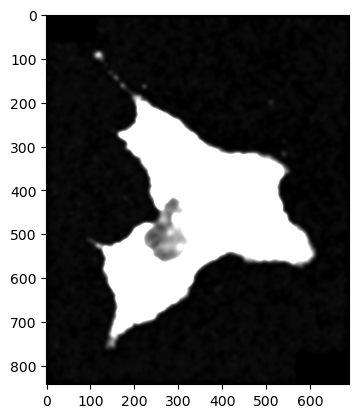

In [50]:
plt.imshow(train_t0_img_smooth, cmap=plt.cm.gray,vmax=0.1,vmin=0)

In [37]:
separating_mask = tifffile.imread('/mnt/d/lding/actomyosin/data/processed_data/separating_MAX_media-2-2.tif')
tifffile.imsave(os.path.join(movie_processed_data_dir, 'separating_mask.tif'),separating_mask)
     

In [29]:
def find_mode_angle(patch_mag, mag_th, patch_ang):
    mode_angle = 0

    patch_ang_values = patch_ang[patch_mag>mag_th]

    hist, bin_edges = np.histogram(patch_ang_values, bins = 16)
    # print(hist)
    # print(bin_edges)

    mode_firstround = bin_edges[np.argmax(hist)] + np.pi/8/2

    mode_angle = mode_firstround

    patch_ang_values[patch_ang_values>mode_angle+np.pi] = patch_ang_values[patch_ang_values>mode_angle+np.pi] - 2*np.pi
    patch_ang_values[patch_ang_values<mode_angle-np.pi] = patch_ang_values[patch_ang_values<mode_angle-np.pi] + 2*np.pi    
    
    patch_ang_values[patch_ang_values>mode_angle+np.pi] = patch_ang_values[patch_ang_values>mode_angle+np.pi] - 2*np.pi
    patch_ang_values[patch_ang_values<mode_angle-np.pi] = patch_ang_values[patch_ang_values<mode_angle-np.pi] + 2*np.pi
    
    hist, bin_edges = np.histogram(patch_ang_values, bins = 16)
    # print(hist)
    # print(bin_edges)
    
    mode_secondround = bin_edges[np.argmax(hist)]+ np.pi/8/2

    mode_angle = mode_secondround

    return mode_angle 

In [30]:
def rotate3d(patch_img,mode_angle):
    output=np.zeros_like(patch_img)
    for i in range(patch_img.shape[0]):
        output[i,:,:] = transform.rotate(patch_img[i,:,:].astype(float), mode_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
    return output

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


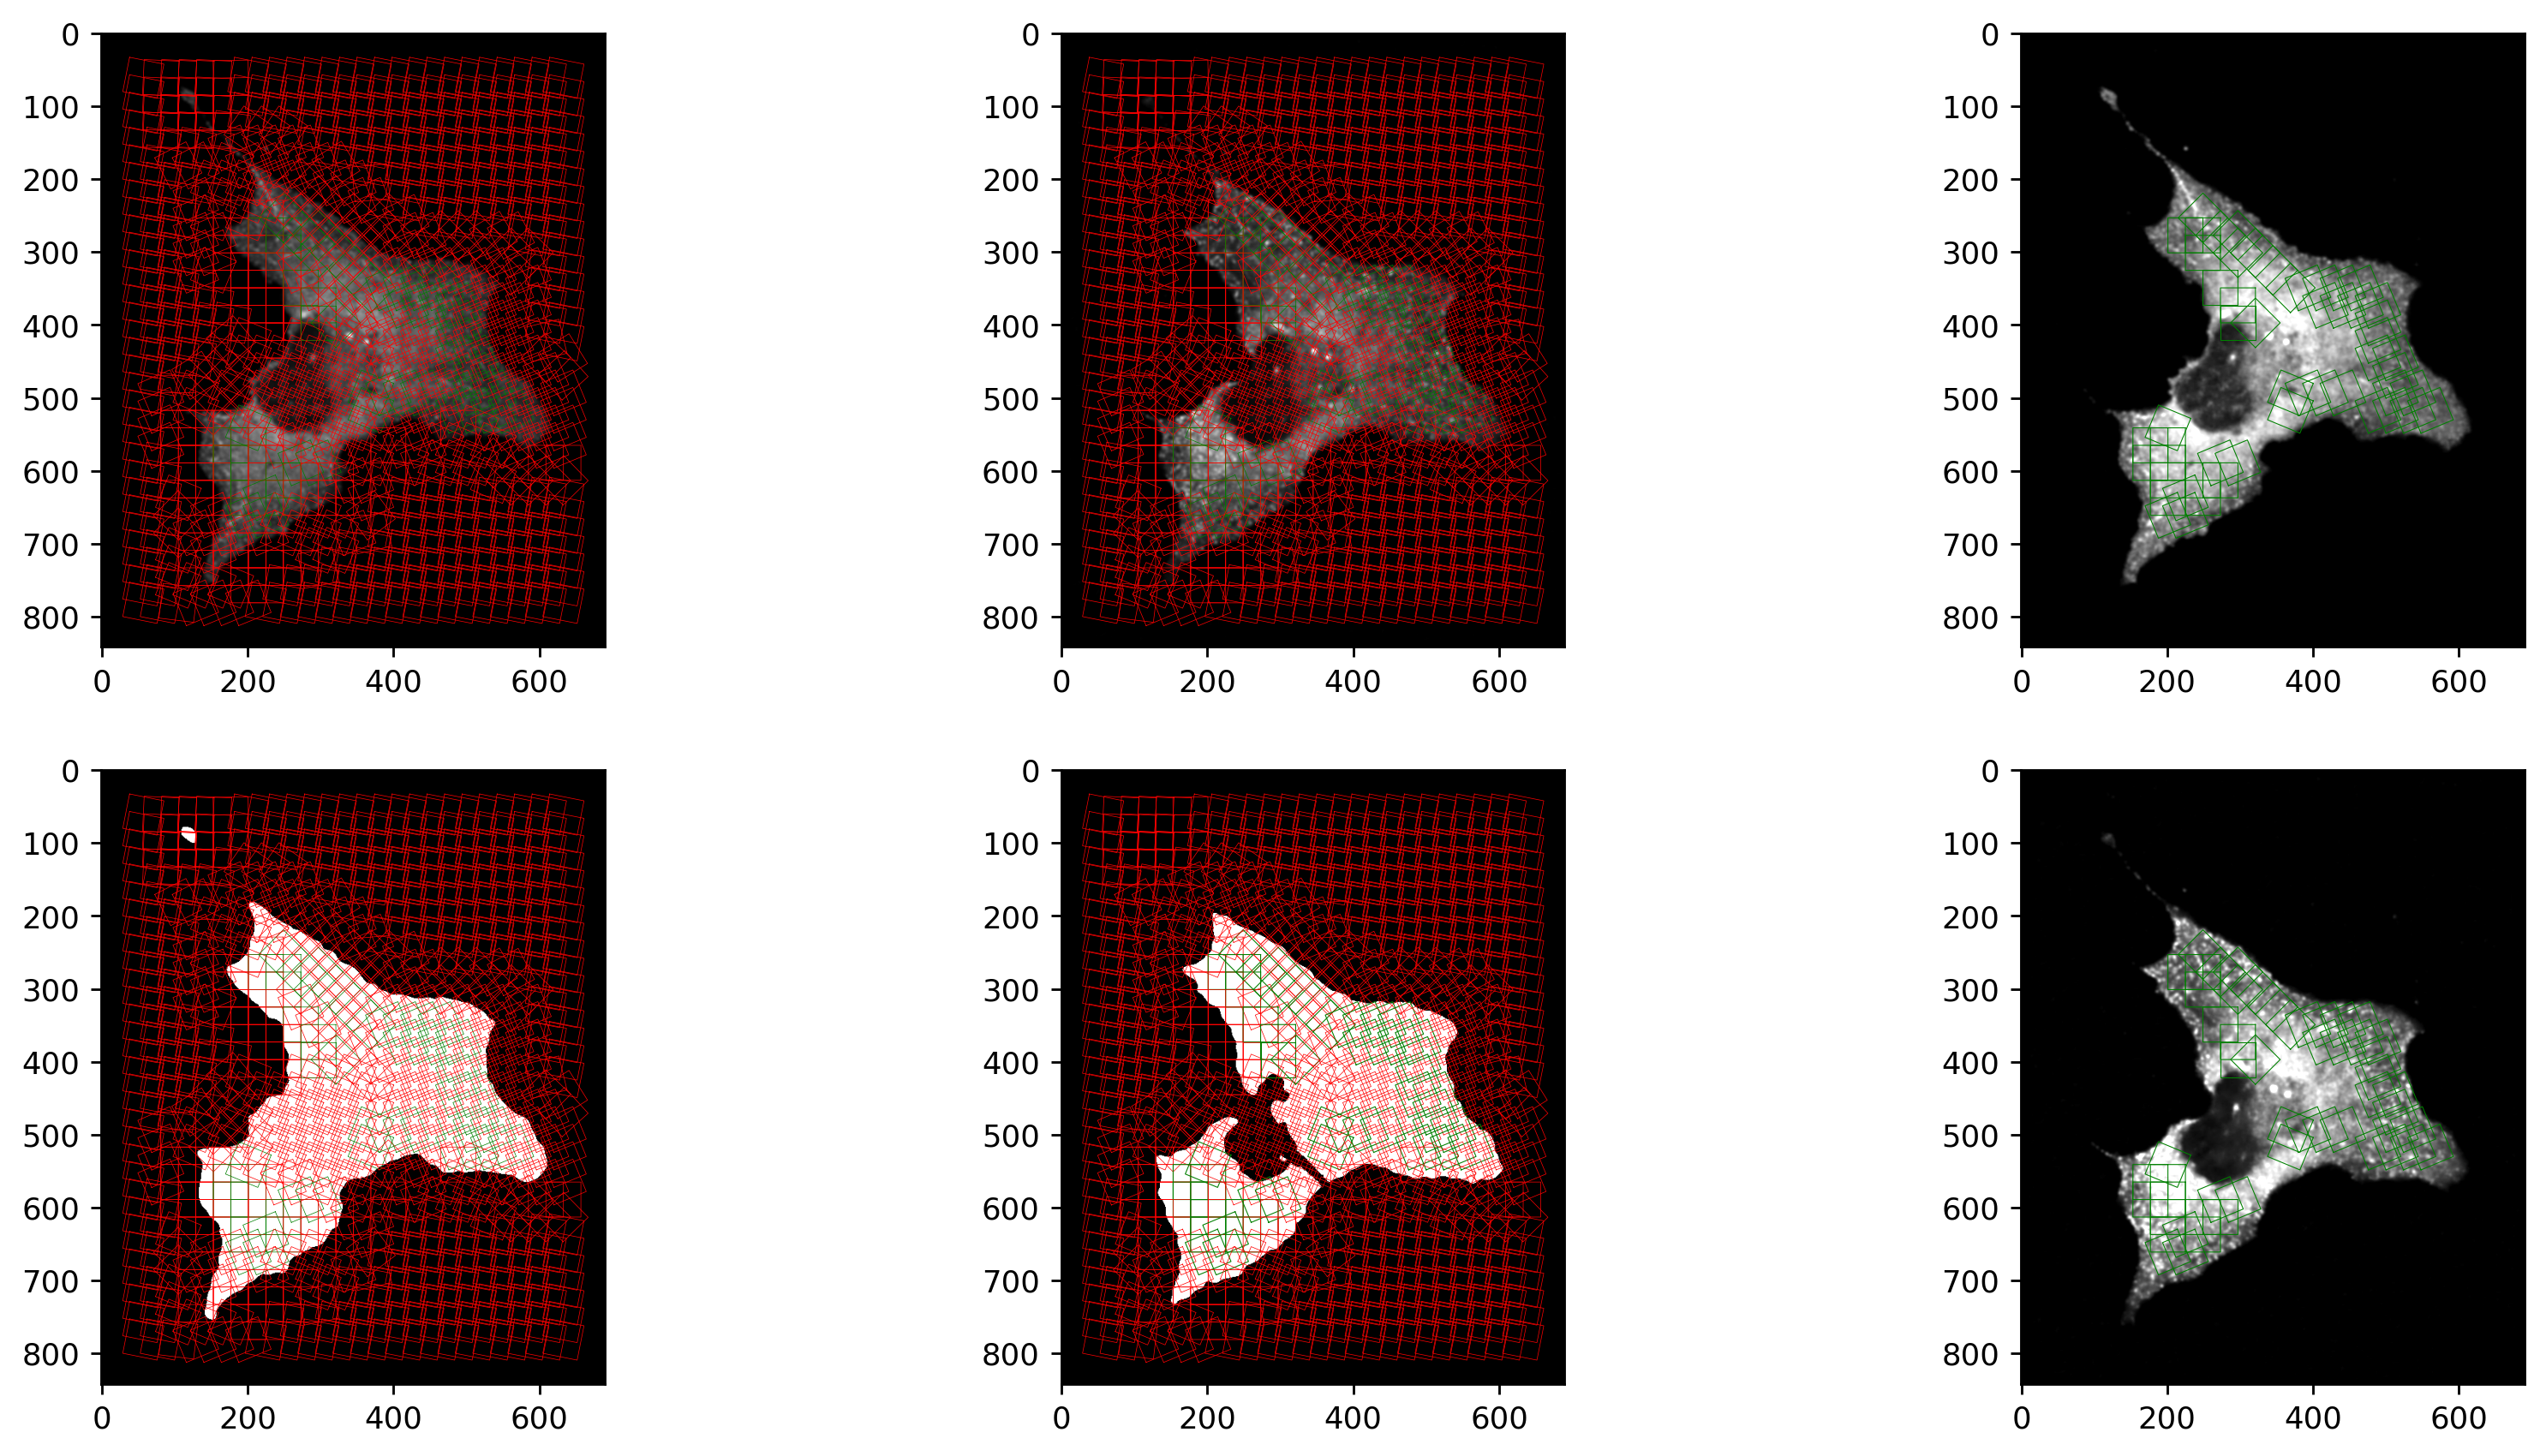

In [55]:
patch_size = 48
halfps = 24
plot_flag = 0
savetiff_flag = 1

filenames = [x for x in os.listdir(movie_dir) if os.path.isfile(os.path.join(movie_dir, x)) and ('.tif' in x)]

for filenameID in [0]:

    filename = filenames[filenameID]

    movie_processed_data_dir =  os.path.join(processed_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')
    movie_partitioned_data_dir =  os.path.join(partitioned_data_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')
    movie_plot_dir =  os.path.join(plot_dir, filename[:-4]+'_ps'+str(patch_size)+'_flows2_thp1_dense_regular')

    if not os.path.isdir(movie_processed_data_dir):
        os.makedirs(movie_processed_data_dir)
    if not os.path.isdir(movie_partitioned_data_dir):
        os.makedirs(movie_partitioned_data_dir)
    if not os.path.isdir(movie_plot_dir):
        os.makedirs(movie_plot_dir)

    img = tifffile.imread(os.path.join(movie_dir,filename))
    smooth_img = ndimage.gaussian_filter(img,sigma=1,mode='nearest',truncate=3)        
    num_of_frames = img.shape[0]
   
    cellmask = tifffile.imread(os.path.join(movie_processed_data_dir, 'cellmask_allframes.tif'))
    mag_all = tifffile.imread(os.path.join(movie_processed_data_dir, 'mag_all.tif'))
    ang_all = tifffile.imread(os.path.join(movie_processed_data_dir, 'ang_all.tif'))    
    separating_mask = tifffile.imread(os.path.join(movie_processed_data_dir, 'separating_mask.tif'))

    x_num = int(np.floor(img.shape[2]/patch_size))
    y_num = int(np.floor(img.shape[1]/patch_size))
    
    x_0 = int((img.shape[2] - x_num*patch_size)/2)
    y_0 = int((img.shape[1] - y_num*patch_size)/2)


    firstframe_img = smooth_img[0,:,:].squeeze()
    firstframe_seg = (cellmask[0,:,:].squeeze())>0
    lastframe_img = smooth_img[-1,:,:].squeeze()
    lastframe_seg = (cellmask[-1,:,:].squeeze() * separating_mask)>0
    from scipy.ndimage import distance_transform_cdt
    distance_lastframe_seg = distance_transform_cdt(lastframe_seg, metric="taxicab")
    distance_firstframe_seg = distance_transform_cdt(firstframe_seg, metric="taxicab")

    fig_accu, ax_accu = plt.subplots(2,3, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
    ax_accu[0,0].imshow(firstframe_img, cmap=plt.cm.gray,vmax=smooth_img.max(),vmin=0)
    ax_accu[0,1].imshow(lastframe_img, cmap=plt.cm.gray,vmax=smooth_img.max(),vmin=0)
    ax_accu[1,0].imshow(firstframe_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
    ax_accu[1,1].imshow(lastframe_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
    
    ax_accu[0,2].imshow(firstframe_img, cmap=plt.cm.gray,vmax=smooth_img.max()/2,vmin=0)
    ax_accu[1,2].imshow(lastframe_img, cmap=plt.cm.gray,vmax=smooth_img.max()/2,vmin=0)
    

    for x_i_half in range(int(x_num/1)*2):
        for y_i_half in range(int(y_num/1)*2):

            x_i = float(x_i_half)/2
            y_i = float(y_i_half)/2


            y_c = int(y_0+(y_i-0.5)*patch_size)
            x_c = int(x_0+(x_i-0.5)*patch_size)

            y_left = y_c - patch_size
            x_left = x_c - patch_size

            y_right = y_c + patch_size
            x_right = x_c + patch_size

            if y_left < 0 or x_left < 0 or y_right >= img.shape[1] or x_right >= img.shape[2]:
                continue

            patch_img = img[:,y_left:y_right,x_left:x_right]
            patch_seg = cellmask[:,y_left:y_right,x_left:x_right]
            patch_ang = ang_all[:,y_left:y_right,x_left:x_right]
            patch_mag = mag_all[:,y_left:y_right,x_left:x_right]
            
            patch_firstframe_img = firstframe_img[y_left:y_right,x_left:x_right]
            patch_firstframe_seg = firstframe_seg[y_left:y_right,x_left:x_right]
            patch_lastframe_img = lastframe_img[y_left:y_right,x_left:x_right]
            patch_lastframe_seg = lastframe_seg[y_left:y_right,x_left:x_right]
            patch_distance_lastframe_seg = distance_lastframe_seg[y_left:y_right,x_left:x_right]
            patch_distance_firstframe_seg = distance_firstframe_seg[y_left:y_right,x_left:x_right]

                
            rand_tx = int(random.random() * halfps - halfps/2)
            rand_ty = int(random.random() * halfps - halfps/2)         
            
            rand_tx = 0
            rand_ty = 0
            
            mag_th = 1

            mode_angle = find_mode_angle(patch_mag, mag_th, patch_ang)*180/(np.pi)

            rotated_patch_img = rotate3d(patch_img,mode_angle)
            
            rotated_patch_firstframe_seg = transform.rotate(patch_firstframe_seg.astype(float), mode_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
            rotated_patch_lastframe_seg = transform.rotate(patch_lastframe_seg.astype(float), mode_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
            rotated_patch_distance_firstframe_seg = transform.rotate(patch_distance_firstframe_seg.astype(float), mode_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
            rotated_patch_distance_lastframe_seg = transform.rotate(patch_distance_lastframe_seg.astype(float), mode_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
                            
            cx_left = halfps-rand_tx
            cx_right = patch_size+halfps-rand_tx
            cy_up = halfps-rand_ty
            cy_down = patch_size+halfps-rand_ty

                        
            crop_patch_firstframe_seg= rotated_patch_firstframe_seg[halfps-rand_ty:patch_size+halfps-rand_ty,halfps-rand_tx:patch_size+halfps-rand_tx]
            crop_patch_lastframe_seg = rotated_patch_lastframe_seg[halfps-rand_ty:patch_size+halfps-rand_ty,halfps-rand_tx:patch_size+halfps-rand_tx]
            crop_patch_distance_firstframe_seg = rotated_patch_distance_firstframe_seg[halfps-rand_ty:patch_size+halfps-rand_ty,halfps-rand_tx:patch_size+halfps-rand_tx]
            crop_patch_distance_lastframe_seg = rotated_patch_distance_lastframe_seg[halfps-rand_ty:patch_size+halfps-rand_ty,halfps-rand_tx:patch_size+halfps-rand_tx]

            flag_good = 1

            # print([crop_patch_firstframe_seg.mean(),crop_patch_lastframe_seg.mean(),crop_patch_distance_firstframe_seg.mean(),crop_patch_distance_lastframe_seg.mean()])

            if((crop_patch_firstframe_seg.mean())<0.98):
                flag_good = 0

            if((crop_patch_lastframe_seg.mean())<0.98):
                flag_good = 0

            if((crop_patch_distance_firstframe_seg.mean())>70):
                flag_good = 0

            if((crop_patch_distance_lastframe_seg.mean())>60):
                flag_good = 0

            X_TransRotCrop = np.array([cx_left, cx_left, cx_right, cx_right, cx_left])
            Y_TransRotCrop = np.array([cy_up, cy_down, cy_down, cy_up, cy_up])

            [X_bigger_patch, Y_bigger_patch] = rotate_coor(X_TransRotCrop,Y_TransRotCrop,patch_size,patch_size,-mode_angle)

            if(flag_good  > 0):
                crop_patch_img = rotated_patch_img[:,halfps-rand_ty:patch_size+halfps-rand_ty,halfps-rand_tx:patch_size+halfps-rand_tx]
                crop_img_filename = 'x'+str(x_c).zfill(4)+'y'+str(y_c).zfill(4)+'ps'+str(patch_size)+'.tif'
                tifffile.imsave(os.path.join(movie_partitioned_data_dir,crop_img_filename), crop_patch_img)

                ax_accu[0,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.2)
                ax_accu[0,1].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.2)
                ax_accu[1,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.2)
                ax_accu[1,1].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.3)
                ax_accu[0,2].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.3)
                ax_accu[1,2].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green',linewidth=0.3)
                
            else:
                ax_accu[0,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='red',linewidth=0.2)
                ax_accu[0,1].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='red',linewidth=0.2)
                ax_accu[1,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='red',linewidth=0.2)
                ax_accu[1,1].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='red',linewidth=0.2)          
        
    fig_accu.savefig(os.path.join(movie_plot_dir,'grid_roi_dense.png'))   
    # plt.close(fig_accu)  

